In [2]:
import os
import torch
from Train.trainer import Trainer

from Train.Preprocessing import (
    filter_collate_fn,
    generate_file_path,
    get_train_transform,
    get_validation_transform
)

from monai.data import (
    DataLoader,
    ThreadDataLoader,
    SmartCacheDataset,
    PersistentDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)

from monai.losses import DiceCELoss

from monai.networks.nets import SwinUNETR
from Train.map_to_binary import class_map_5_parts
from monai.data.utils import pad_list_data_collate


MONAI version: 1.2.dev2313
Numpy version: 1.23.5
Pytorch version: 2.0.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 331437dfce075b4fa5785016ad4e7f8c7c77ad21
MONAI __file__: D:\Arash\Semester2\DeepLearning\FinalProject\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.0.1
scikit-image version: 0.20.0
Pillow version: 9.4.0
Tensorboard version: 2.12.0
gdown version: 4.7.1
TorchVision version: 0.15.1+cu118
tqdm version: 4.65.0
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.27.3
mlflow version: 2.2.2
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
task_name = 'organs'
val_transforms = get_validation_transform()
train_transforms = get_train_transform(num_samples=4)

# Load Dataset

In [4]:
root_dataset = 'DatasetCombined'
label_name = f'labels_task_{task_name}'
# file_list_val = generate_file_path(root_path=f'{root_dataset}/val', label_name=label_name)
# file_list_train = generate_file_path(root_path=f'{root_dataset}/train', label_name=label_name)

In [4]:
file_list_val = generate_file_path(root_path=f'{root_dataset}/val', label_name=label_name)
file_list_train = generate_file_path(root_path=f'{root_dataset}/train', label_name=label_name)

KeyboardInterrupt: 

In [ ]:
train_ds = PersistentDataset(
    data=file_list_train,
    transform=train_transforms,
    cache_dir=f'C:/Training/train_{task_name}'
)

train_loader = ThreadDataLoader(train_ds, batch_size=1, shuffle=True,
                                collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96))
                               )

In [5]:
val_ds = PersistentDataset(
    data=file_list_val,
    transform=val_transforms,
    cache_dir=f'val_{task_name}'
#     cache_dir='C:/Training/val'
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=0,
                              collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96)))

In [5]:
num_of_classes = len(class_map_5_parts[f'class_map_part_{task_name}']) + 1
num_of_classes

18

# Model

In [6]:
root_dir = 'Model'
model_folder = os.path.join(root_dir, f'SwinTransformer_{task_name}')
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)

In [7]:
model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=num_of_classes,
    feature_size=48,
#     drop_rate=0.25,
    use_checkpoint=True,
)

In [8]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=1, lambda_ce=1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [9]:
swin_trainer = Trainer(
    model=model,
    max_epoch=1000,
    optimizer=optimizer,
    num_samples=4,
    loss_function=loss_function,
    model_root_path=model_folder,
    number_of_classes=num_of_classes,
    )
swin_trainer.load_weights()

Adjusting learning rate of group 0 to 1.0000e-04.


In [11]:
torch.backends.cudnn.benchmark = True
swin_trainer.train(train_loader, val_loader)

Training (0 / 1000 Steps) (loss=1.76350):  49%|██████████████████▏                  | 493/1004 [06:06<06:19,  1.35it/s]


KeyboardInterrupt: 

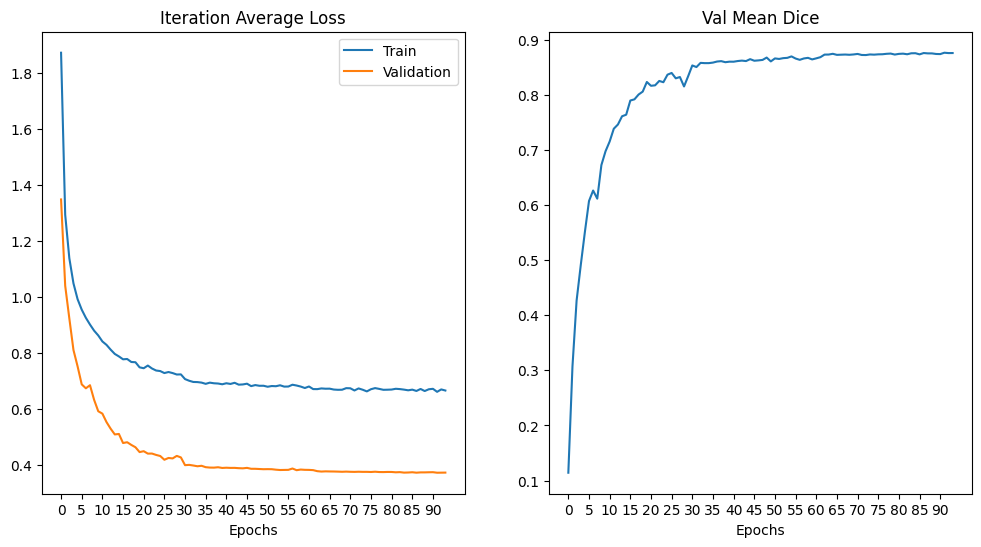

In [9]:
swin_trainer.plot_train_info()

In [10]:
file_list_test = generate_file_path(root_path=f'{root_dataset}/test', label_name=label_name)
test_ds = PersistentDataset(
    data=file_list_test,
    transform=val_transforms,
    cache_dir=f'test_{task_name}'
#     cache_dir='C:/Training/val'
)

test_loader = DataLoader(test_ds, num_workers=0, batch_size=1, 
                              collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96)))

In [11]:
torch.cuda.empty_cache()

In [12]:
torch.cuda.empty_cache()
swin_trainer.test(test_loader)

Test:   0%|                                                                                     | 0/64 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None
invalid value encountered in double_scalars
torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
Test (loss=0.14857): 100%|█████████████████████████████████████████████████████████████| 64/64 [15:07<00:00, 14.19s/it]


([0.9738089344220136,
  0.9541534055713502,
  0.9191515738947812,
  0.8051819266003523,
  0.967125680801371,
  0.9156355314738855,
  0.954485496917944,
  0.8909358647117234,
  0.8139417534692616,
  0.8253318866839834,
  0.8324045870067357,
  0.8444926172111881,
  0.9301465447019448,
  0.9322194928611033,
  0.9431807532128501,
  0.9072544595991416,
  0.9338983161283796],
 [3.079818550792234,
  13.246632339117356,
  18.10922544759165,
  25.32663155358954,
  12.214815891693792,
  9.857334249399823,
  4.2603154772221385,
  11.44053444037137,
  15.947266019576928,
  20.39961190990202,
  15.827383231358436,
  10.920990652373236,
  11.418046177183891,
  13.533546479840172,
  9.7167743376693,
  8.543783484601223,
  12.877110333168728],
 [0.97543309218124,
  0.9799627386287003,
  0.9336781454134427,
  0.8855683861847888,
  0.9711682226670876,
  0.9024497150267999,
  0.9773189436244285,
  0.9438647209584788,
  0.9036299386491415,
  0.9081528822930034,
  0.9670381222679063,
  0.9735653117692715,


In [ ]:
for t in train_loader:
    if t['label'].max() == 0:
        print(t['label'].min(), t['label'].max() == 0)
    break